In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, InputLayer, Input, Reshape
from tensorflow.keras.layers import Activation, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Adversarial attack method. The latest release of the `cleverhans` package does
# not support TensrFlow 2 yet, so we need to install from the master branch:
# pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
from cleverhans.future.tf2.attacks import projected_gradient_descent

from odcd.models.losses import loss_adv_vae
from odcd.ad import AdversarialVAE
from odcd.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load MNIST data

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Create and train MNIST model

In [3]:
load_mnist_model = False

In [4]:
filepath = './model_mnist/'
if load_mnist_model:
    model = load_tf_model(filepath)
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]))
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=5,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    
    # save model
    save_tf_model(model, filepath)
    
# evaluate model
results = model.evaluate(x_test, y_test, batch_size=256)
print('test loss, test acc:', results)

## Train Adversarial VAE for MNIST

In [12]:
load_adversarial_detector = False

In [13]:
filepath = './ad_vae_mnist/'
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = 50
    
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(28, 28, 1)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7*7*32, activation=tf.nn.relu),
          Reshape(target_shape=(7, 7, 32)),
          Conv2DTranspose(64, 3, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(32, 3, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid')
      ])
    
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    
    # train
    ad.fit(X_train,
           loss_fn=loss_adv_vae,
           w_model=1.,
           w_recon=0.,
           epochs=2,
           verbose=True)
    
    # save the trained outlier detector
    save_detector(ad, filepath)

No threshold level set. Need to infer threshold using `infer_threshold`.


938/938 [=] - 275s 293ms/step - loss: 0.0257


## Generate adversarial instances

The `cleverhans` adversarial attack methods assume that the model outputs logits, so we will create a modified model by simply removing the softmax output layer:

In [16]:
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Select observations for which we will create adversarial instances:

In [17]:
ids = np.arange(5)
X_to_adv = X_test[ids]
print(X_to_adv.shape)

(5, 28, 28, 1)


Launch adversarial attack. Follow the [Basic Iterative Method (Kurakin et al. 2016)](https://arxiv.org/pdf/1607.02533.pdf) when `rand_init` is set to 0 or the [Madry et al. (2017)](https://arxiv.org/pdf/1706.06083.pdf) method when `rand_minmax` is larger than 0:

In [18]:
X_adv = projected_gradient_descent(model_logits,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()

Visualize adversarial instances with model predictions:

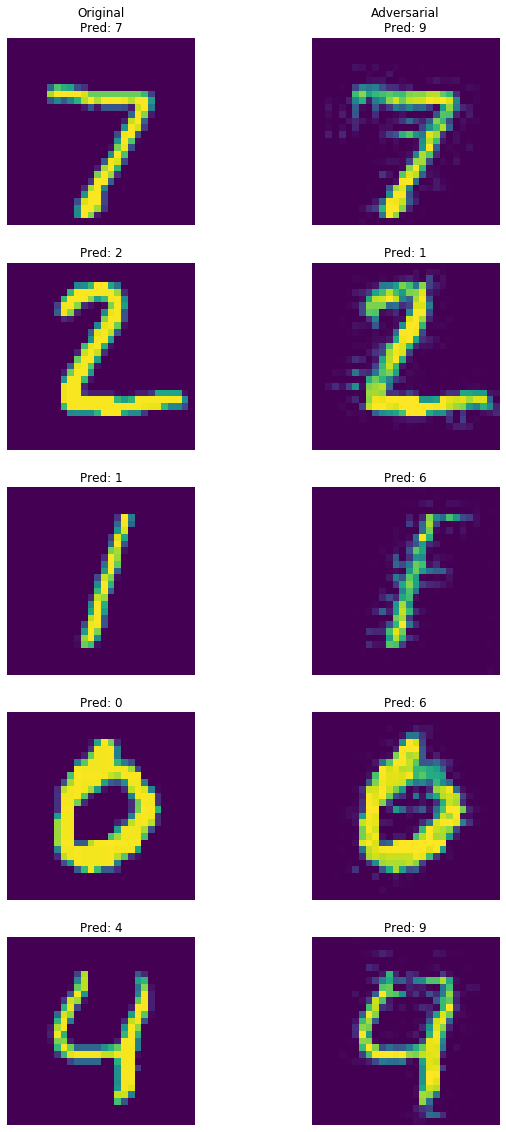

In [44]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)

n_rows = X_to_adv.shape[0]
figsize = (10, 20)
img_shape = (28, 28)

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=figsize)

n_subplot = 1
for i in range(n_rows):
    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Original'
                  '\nPred: {}'.format(y_pred[i]))
    else:
        plt.title('Pred: {}'.format(y_pred[i]))
    plt.imshow(X_to_adv[i].reshape(img_shape))
    n_subplot += 1

    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial'
                  '\nPred: {}'.format(y_pred_adv[i]))
    else:
        plt.title('Pred: {}'.format(y_pred_adv[i]))
    plt.imshow(X_adv[i].reshape(img_shape))
    n_subplot += 1
plt.show()

## Detect adversarial instances

In [49]:
X = np.concatenate([X_to_adv, X_adv], axis=0)
print(X.shape)

(10, 28, 28, 1)


In [53]:
ad_preds = ad.predict(X, return_instance_score=True)

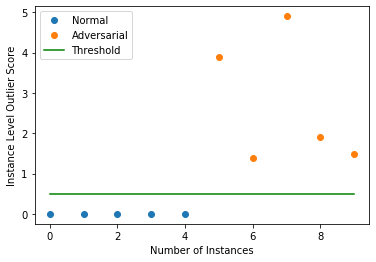

In [61]:
labels = ['Normal', 'Adversarial']
target = np.array([0 if i < X_to_adv.shape[0] else 1 for i in range(X.shape[0])])
plot_instance_outlier(ad_preds, target, labels, ad.threshold)

The adversarial detector easily separates the normal from adversarial instances. We can plot the individual instances again with their adversarial scores:

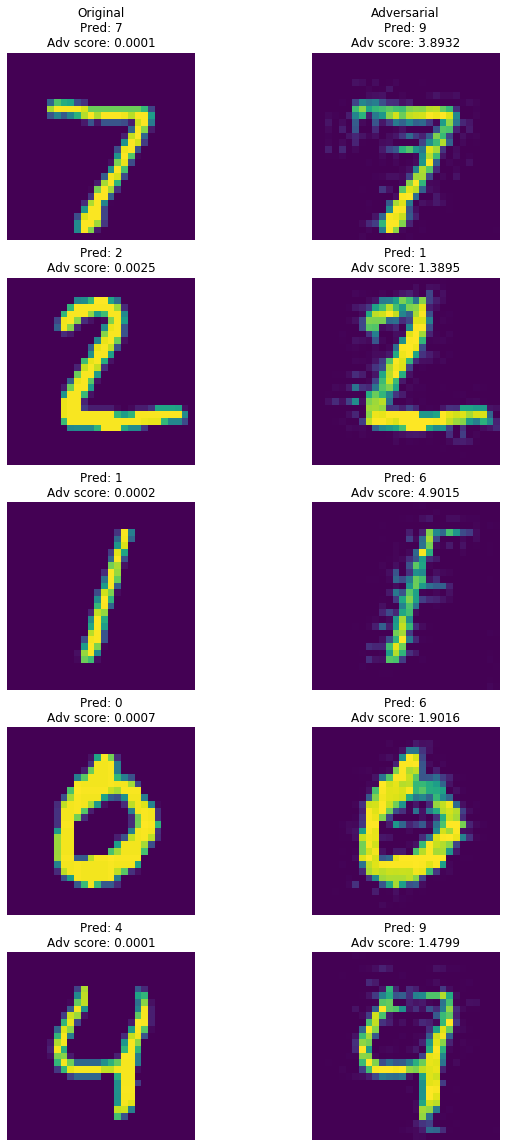

In [73]:
scores = ad_preds['data']['instance_score']

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=figsize)

n_subplot = 1
for i in range(n_rows):
    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Original'
                  '\nPred: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[i], scores[i]))
    else:
        plt.title('Pred: {}'
                  '\nAdv score: {:.4f}'.format(y_pred[i], scores[i]))
    plt.imshow(X_to_adv[i].reshape(img_shape))
    n_subplot += 1

    plt.subplot(n_instances, n_cols, n_subplot)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial'
                  '\nPred: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[i], scores[i + n_rows]))
    else:
        plt.title('Pred: {}'
                  '\nAdv score: {:.4f}'.format(y_pred_adv[i], scores[i + n_rows]))
    plt.imshow(X_adv[i].reshape(img_shape))
    n_subplot += 1
plt.show()